In [1]:
import numpy as np
import cv2 as cv
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imutils
import glob
import warnings
import os
import tqdm
import random

In [2]:
random.seed(42)
np.random.seed(42)
# cv.setRNGSeed(42)

PATHS = namedtuple('_', ('mosaic', 'stereo'))('../images/Image Mosaicing/', '../images/Stereo Correspondence/')
StereoPair = namedtuple('StereoPair', ('left', 'right'))



def read_files_q1(idx):
    files = sorted(glob.glob(PATHS.mosaic + str(idx) +'_*'))
    images = []
    for f in files:
        img = cv.imread(f)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
        images.append(img)
    return images

def read_files_q2(idx):
    files = sorted(glob.glob(PATHS.stereo + str(idx) +'_*'))
    images = []
    for f in files:
        img = cv.imread(f)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
        images.append(img)
    return StereoPair(*images)

def show(obj, now=True):
    if not isinstance(obj, StereoPair):
        fig, axs = plt.subplots(figsize=(6, 6))
        axs.imshow(obj)
        axs.axis('off')
        if now:
            plt.show()
        else:
            return fig, axs
    else:
        fig, (axl, axr) = plt.subplots(1, 2, figsize=(12,6))
        axl.imshow(obj.left)
        axr.imshow(obj.right)
        axl.axis('off')
        axr.axis('off')
        if now:
            plt.show()
        else:
            return fig, (axl, axr)

## Question 1

In [3]:
TOL = 5
NUM_ITR = 1000

In [4]:
def get_matches(img1, img2):
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # match
    flann = cv.FlannBasedMatcher({'algorithm': 1, 'trees': 5}, {'checks': 50})
    matches_raw = flann.knnMatch(des1, des2, k=2)

    matches = []
    for m in matches_raw:
        if m[0].distance < 0.7 * m[1].distance:
            matches.append(m)
    
    points1 = np.array([kp1[m[0].queryIdx].pt for m in matches], dtype=np.float64)
    points2 = np.array([kp2[m[0].trainIdx].pt for m in matches], dtype=np.float64)

    return points1, points2

def find_homography(src, dst):
    
    A = [[] for i in range(2 * src.shape[0])]

    for i in range(src.shape[0]):
        Xi = src[i]
        xi = dst[i]
        A[2 * i] = [Xi[0], Xi[1], 1, 0, 0, 0, -xi[0]*Xi[0], -xi[0]*Xi[1], -xi[0]]
        A[(2 * i) + 1] = [0, 0, 0, Xi[0], Xi[1], 1, -xi[1]*Xi[0], -xi[1]*Xi[1], -xi[1]]

    A = np.array(A, dtype=np.float64)
    u, d, vh = np.linalg.svd(A)

    if vh is None:
        warnings.warn('Could not compute H')
        return np.eye(3)

    H = vh[8].reshape((3, 3))
    H = H / H[2, 2]
    return H

def to_homogenous(x):
    return np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)


def project_points(P, X):
    X_ = to_homogenous(X)
    x = P @ X_.T
    x = x / x[2]
    return x.T[:, :2]

def find_homography_ransac(src, dst, tol=TOL, num_itr=NUM_ITR):
    
    best_H = None
    best_thresh = 0

    for i in range(num_itr):
        rand_idx = np.random.choice(dst.shape[0], size=5, replace=False)
        dst_r = dst[rand_idx, :]
        src_r = src[rand_idx, :]

        H = find_homography(src_r, dst_r)
        pred_dst = project_points(H, src)

        count = 0
        for i in range(src.shape[0]):
            e = np.linalg.norm(pred_dst[i, :] - dst[i, :])
            if e < tol:
                count += 1
        
        if count/src.shape[0] >= best_thresh:
            best_H = H
            best_thresh = count/src.shape[0]

    return best_H


In [5]:
def crop(img_):
    try:
        img = img_.copy()
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY)

        cnts = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv.contourArea)
        (x, y, w, h) = cv.boundingRect(c)
        img = img[y:y + h, x:x + w]
        return img
    except:
        return img_

def overlap(img_bot, img_top):
    # pick pixels from img_top and place on img_bot
    for i in range(img_top.shape[0]):
        for j in range(img_top.shape[1]):
            if list(img_bot[i, j, :]) == [0, 0, 0]: # if bottom is black, freely replace
                img_bot[i, j, :] = img_top[i, j, :]
            elif list(img_top[i, j, :]) != [0, 0, 0]: # if bottom is not black, only replace if top is also not black
                img_bot[i, j, :] = img_top[i, j, :]
    return img_bot

def get_dim(img1, H, img2):
    corners1 = np.array([
        [0,                         0],
        [0,             img1.shape[0]],
        [img1.shape[1], img1.shape[0]],
        [img1.shape[1],             0],
    ], dtype=np.float64)
    
    corners1 = project_points(H, corners1)
    
    corners2 = np.array([
        [0,                         0],
        [0,             img2.shape[0]],
        [img2.shape[1], img2.shape[0]],
        [img2.shape[1],             0],
    ], dtype=np.float64)
    
    x_cords = np.concatenate((corners1[:, 0], corners2[:, 0]))
    y_cords = np.concatenate((corners1[:, 1], corners2[:, 1]))
    
    width = int(np.ceil(np.max(x_cords) - np.min(x_cords)))
    height = int(np.ceil(np.max(y_cords) - np.min(y_cords)))
    return width, height, (np.min(x_cords), np.min(y_cords))
    

def stitch_two(img1, img2): # img1 is new, img2 is base
    points1, points2 = get_matches(img1, img2)
    H = find_homography_ransac(points1, points2)
    
    width, height, min_point = get_dim(img1, H, img2)
    T = np.array([
        [1, 0, -min_point[0]],
        [0, 1, -min_point[1]],
        [0, 0,             1],
    ])
    
#     result_width = int(np.floor(1.5 * (img1.shape[1] + img2.shape[1])))
#     result_height = int(np.floor(1.5 * (img1.shape[0] + img2.shape[0])))

    img1_ = cv.warpPerspective(img1, T @ H, (width, height))
    img2_ = cv.warpPerspective(img2, T, (width, height))
    # show(img2_)
    # img2_ = crop(img2_)
    return overlap(img1_, img2_)

In [6]:
def panaroma(images):
    if len(images) == 0:
        return
    
    base = images[0]
    for img in tqdm.tqdm(images[1:]):
        base = crop(stitch_two(img, base))
        

    return crop(base)

100%|██████████| 3/3 [11:14<00:00, 224.83s/it]


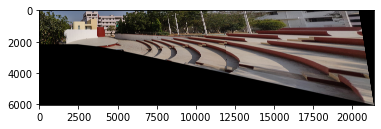

In [28]:
images = read_files_q1(1)
img = panaroma(images)
plt.imshow(img)

100%|██████████| 5/5 [00:47<00:00,  9.56s/it]


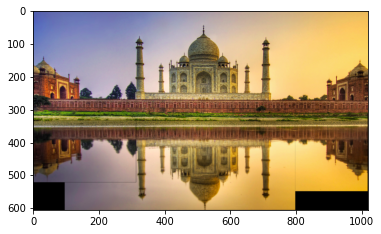

In [25]:
images = read_files_q1(2)
img = panaroma(images)
plt.imshow(img)

100%|██████████| 1/1 [00:28<00:00, 28.72s/it]


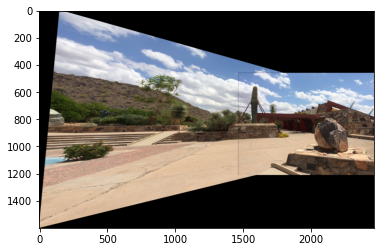

In [126]:
images = read_files_q1(3)[::-1]
img = panaroma(images)
plt.imshow(img)

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


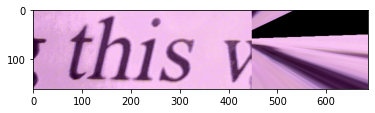

In [26]:
images = read_files_q1(4)
img = panaroma(images)
plt.imshow(img)

100%|██████████| 3/3 [08:14<00:00, 164.79s/it]


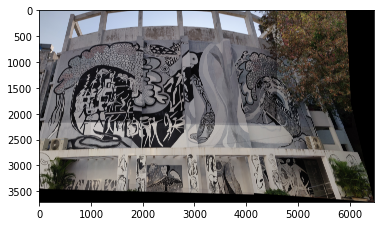

In [27]:
images = read_files_q1(5)
img = panaroma(images)
plt.imshow(img)

### Question 1 bonus

In [7]:
BONUS_THRESH = 100

In [11]:
def stitch_two_bonus(img1_, img2_, thresh): # img1 is new, img2 is base
    img1 = img1_.copy()
    img2 = img2_.copy()

    points1, points2 = get_matches(img1, img2)
    if len(points1) < thresh:
        return

    H = find_homography_ransac(points1, points2)
    
    width, height, min_point = get_dim(img1, H, img2)
    T = np.array([
        [1, 0, -min_point[0]],
        [0, 1, -min_point[1]],
        [0, 0,             1],
    ])

    img1_ = cv.warpPerspective(img1, T @ H, (width, height))
    img2_ = cv.warpPerspective(img2, T, (width, height))
    return overlap(img1_, img2_)

def panaroma_bonus(images_, thresh=BONUS_THRESH):
    images = deque(images_)
    if len(images) == 0:
        return
    
    base = images[0]
    images.popleft()
    while len(images) > 0:
        img = images[0]
        images.popleft()

        res = stitch_two_bonus(img, base, thresh)
        if res is None:
            print('-', end='')
            images.append(img)
        else:
            base = crop(res)
        
    return base

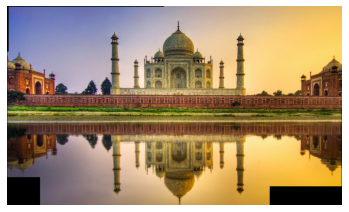

In [14]:
images = read_files_q1(2)
random.shuffle(images)
img = panaroma_bonus(images)
show(img)

## Question 2

### Question 2.1

In [8]:
SEARCH_SIZE = 25
WINDOW_SIZE = 5
NUM_POINTS = 20

In [9]:
def correlation(win1_, win2_):
    '''
    Assuming win1 and win2 are black and white
    '''
    if win1_.ndim != 2 or win1_.shape != win2_.shape:
        raise ValueError('Arguments must be 2D arrays of equal sizes.')

    win1 = win1_ - np.mean(win1_)
    win2 = win2_ - np.mean(win2_)

    num = np.sum(win1 * win2)
    den = np.sqrt(np.sum(win1 ** 2) * np.sum(win2 ** 2)) + 1e-3
    return num/den

def GenCoords(x_range, y_range):
    seen = set()

    x, y = random.randint(*x_range), random.randint(*y_range)

    while True:
        seen.add((x, y))
        yield (x, y)
        x, y = random.randint(*x_range), random.randint(*y_range)
        while (x, y) in seen:
            x, y = random.randint(*x_range), random.randint(*y_range)

def get_safe_points(shape1, shape2, buffer, num):
    row_range = (buffer + 1, min(shape1[0], shape2[0]) - buffer)
    col_range = (buffer + 1, min(shape1[1], shape2[1]) - buffer)

    coords = []
    g = GenCoords(row_range, col_range)
    for _ in range(num):
        coords.append(next(g))
    return coords

def get_corr_match(neigh, search_space, win_sz):
    best_point = None
    best_corr = 0

    for i in range(win_sz, search_space.shape[0] - win_sz):
        for j in range(win_sz, search_space.shape[1] - win_sz):
            corr = correlation(neigh, search_space[i-win_sz:i+win_sz, j-win_sz:j+win_sz])
            # print(corr)
            if corr >= best_corr:
                best_corr = corr
                best_point = (i, j)
    return best_point

def intensity_window_correlation(pair_, num=NUM_POINTS, search_sz=SEARCH_SIZE, win_sz=WINDOW_SIZE):
    pair = StereoPair(cv.cvtColor(pair_.left, cv.COLOR_RGB2GRAY), cv.cvtColor(pair_.right, cv.COLOR_RGB2GRAY))
    
    buffer = search_sz + win_sz
    left_pts = get_safe_points(pair.left.shape, pair.right.shape, buffer, num)
    right_pts = []

    for (i, j) in left_pts:
        neigh = pair.left[i-win_sz:i+win_sz, j-win_sz:j+win_sz]
        search_space = pair.right[i-buffer:i+buffer, j-buffer:j+buffer]
        selected = get_corr_match(neigh, search_space, win_sz)
        selected = (selected[0] + i - buffer, selected[1] + j - buffer)
        right_pts.append(selected)

    left_pts = np.array(left_pts)
    right_pts = np.array(right_pts)

    fig, (axl, axr) = show(pair_, False)
    colors = np.random.uniform(low=0, high=1, size=left_pts.shape[0])
    axl.scatter(left_pts[:, 1], left_pts[:, 0], s=15, alpha=0.8, cmap='rainbow', c=colors)
    axr.scatter(right_pts[:, 1], right_pts[:, 0], s=15, alpha=0.8, cmap='rainbow', c=colors)
    plt.show()
    


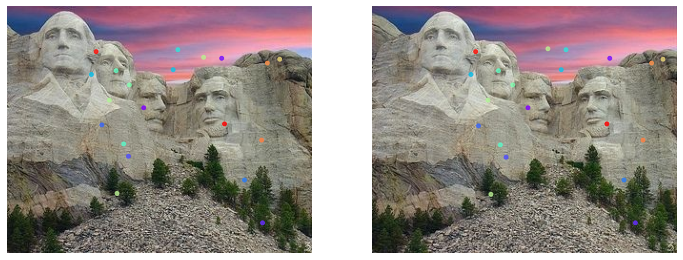

In [133]:
intensity_window_correlation(read_files_q2(1))

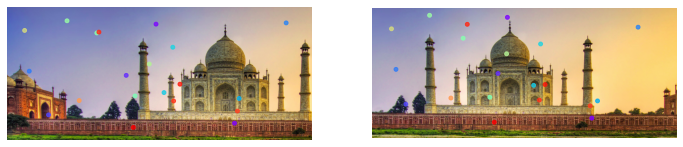

In [134]:
intensity_window_correlation(read_files_q2(2))

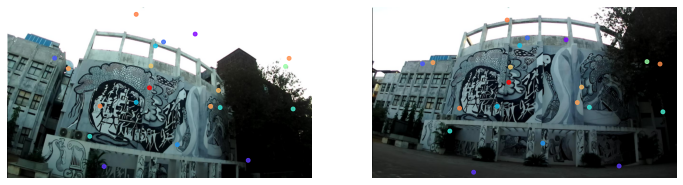

In [135]:
intensity_window_correlation(read_files_q2(3))

### Question 2.2

In [10]:
NUM_LINES = 15

In [71]:
def get_fundamental_matrix(pair):
    left_pts, right_pts = get_matches(pair.left, pair.right)
    # print(left_pts.shape, right_pts.shape)
    F, mask = cv.findFundamentalMat(left_pts, right_pts, cv.FM_LMEDS)
    # return F, left_pts[mask.ravel() == 1], right_pts[mask.ravel() == 1]
    return F, left_pts, right_pts

def abcline(params, axs):
    if not np.isclose(params[1], 0):
        slope = -params[0] / params[1]
        intercept = -params[2] / params[1]

        x_vals = np.array(axs.get_xlim())
        y_vals = intercept + slope * x_vals
        
    elif not np.isclose(params[0], 0):
        x_vals = np.array([-params[2]/params[0]] * 2)
        y_vals = np.array(axs.get_ylim())
    else:
        raise ValueError('Invalid Line.')
    
    axs.autoscale(False)
    axs.plot(x_vals, y_vals, '-')
    return axs

def cvline(params, width):
    a, b, c = params
    
    x = [0, int(width)]
    y = [int((-a * i / b) - (c / b)) for i in x]

    ret = list(zip(x, y))
    return np.array(ret)

def get_colors(n):

    colors = [
        (1,100,211),
        (174,212,46),
        (100,52,183),
        (85,188,47),
        (190,97,233),
        (1,197,87),
        (226,89,219),
        (0,153,32),
        (232,42,163),
        (107,221,136),
        (248,44,151),
        (0,117,48),
        (177,124,255),
        (222,164,0),
        (122,126,255),
        (252,147,20),
        (70,68,175),
        (168,147,0),
        (117,48,164),
        (177,209,131),
        (179,0,135),
        (1,219,210),
        (232,11,80),
        (13,217,245),
        (255,122,39),
        (0,96,179),
        (208,92,0),
        (3,184,242),
        (163,46,0),
        (133,160,255),
        (188,102,0),
        (235,135,255),
        (59,92,26),
        (255,98,193),
        (1,147,107),
        (210,0,107),
        (127,216,174),
        (255,71,89),
        (1,98,150),
        (255,135,71),
        (149,181,255),
        (128,111,0),
        (254,161,255),
        (236,192,99),
        (121,55,134),
        (210,200,126),
        (155,20,106),
        (255,157,100),
        (76,75,142),
        (130,66,0),
        (212,187,252),
        (164,19,40),
        (76,117,165),
        (145,52,27),
        (249,172,245),
        (128,64,53),
        (255,141,215),
        (255,153,127),
        (134,50,111),
        (240,167,158),
        (146,44,84),
        (180,145,195),
        (255,103,163),
        (129,72,105),
        (255,159,165),
        (255,165,200),
        (0, 0, 0),
    ]
    n = n % len(colors)
    return colors[n]

def plot_epipolar_lines(pair, left_pts_, right_pts_, F, num=NUM_LINES):
    
    # indices = np.random.choice(left_pts_.shape[0], size=num, replace=False)
    left_pts = left_pts_[:num]
    right_pts = right_pts_[:num]

    left_pts_h = to_homogenous(left_pts)
    right_pts_h = to_homogenous(right_pts)

    right_lines = (F   @  left_pts_h.T).T
    left_lines  = (F.T @ right_pts_h.T).T
    # each row is a line now

    left_image = pair.left.copy()
    for i, line in enumerate(left_lines):
        # abcline(line, axl)
        points = cvline(line, pair.left.shape[1])
        left_image = cv.line(left_image, (points[0, 0], points[0, 1]), (points[1, 0], points[1, 1]), get_colors(i), 2)
    
    right_image = pair.right.copy()
    for i, line in enumerate(right_lines):
        # abcline(line, axr)
        points = cvline(line, pair.right.shape[1])
        right_image = cv.line(right_image, (points[0, 0], points[0, 1]), (points[1, 0], points[1, 1]), get_colors(i), 2)

    for i, point in enumerate(left_pts):
        left_image = cv.circle(left_image, (int(point[0]), int(point[1])), 4, get_colors(i+30), thickness=-1)
    for i, point in enumerate(right_pts):
        right_image = cv.circle(right_image, (int(point[0]), int(point[1])), 4, get_colors(i+30), thickness=-1)

    pair_plotted = StereoPair(left_image, right_image)
    return pair_plotted


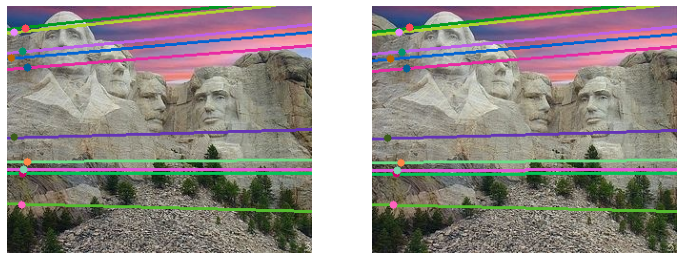

In [72]:
pair = read_files_q2(1)
F, left_pts, right_pts = get_fundamental_matrix(pair)
pair = plot_epipolar_lines(pair, left_pts, right_pts, F, 10)
show(pair)

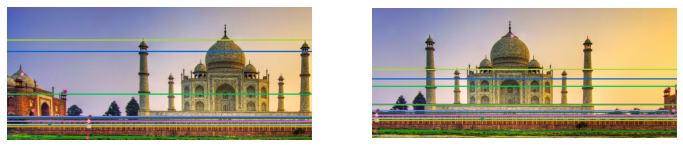

In [73]:
pair = read_files_q2(2)
F, left_pts, right_pts = get_fundamental_matrix(pair)
pair = plot_epipolar_lines(pair, left_pts, right_pts, F, 15)
show(pair)

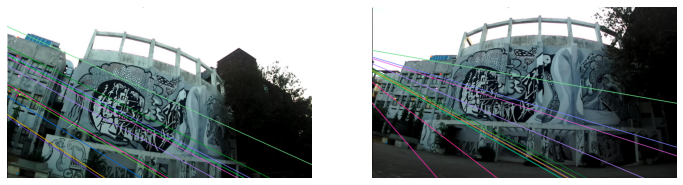

In [74]:
pair = read_files_q2(3)
F, left_pts, right_pts = get_fundamental_matrix(pair)
pair = plot_epipolar_lines(pair, left_pts, right_pts, F, 15)
show(pair)

### Question 2.3

In [75]:
def find_transformed_size(H, shape):
    corners = np.array([
        [0,               0],
        [0,        shape[0]],
        [shape[1], shape[0]],
        [shape[1],        0],
    ], dtype=np.float64)
    
    corners = project_points(H, corners)
    width  = int(np.ceil(np.max(corners[:, 0]) - np.min(corners[:, 0])))
    height = int(np.ceil(np.max(corners[:, 1]) - np.min(corners[:, 1])))
    return width, height


def stereo_rectify(pair_, F, left_pts, right_pts):
    # crop to same size
    height = min(pair_.left.shape[0], pair_.right.shape[0])
    width  = min(pair_.left.shape[1], pair_.right.shape[1])
    pair = StereoPair(pair_.left.copy()[:height, :width], pair_.right.copy()[:height, :width])

    # compute homography
    _, H_left, H_right = cv.stereoRectifyUncalibrated(left_pts, right_pts, F, (width, height))
    left_size  = find_transformed_size(H_left, pair.left.shape)
    right_size = find_transformed_size(H_right, pair.right.shape)

    rect_left = crop(cv.warpPerspective(pair.left, H_left, left_size))
    rect_right = crop(cv.warpPerspective(pair.right, H_right, right_size))

    return StereoPair(rect_left, rect_right)


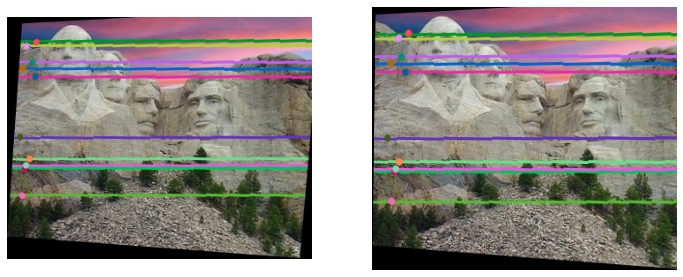

In [82]:
pair_1 = read_files_q2(1)
F, left_pts, right_pts = get_fundamental_matrix(pair_1)
pair_1 = plot_epipolar_lines(pair_1, left_pts, right_pts, F, 10)
pair_1 = stereo_rectify(pair_1, F, left_pts, right_pts)
show(pair_1)

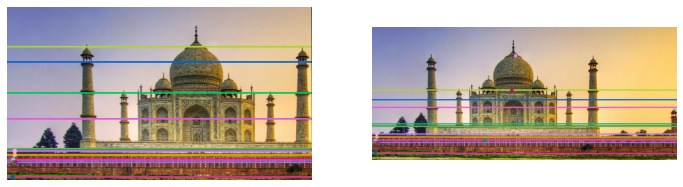

In [84]:
pair_2 = read_files_q2(2)
F, left_pts, right_pts = get_fundamental_matrix(pair_2)
pair_2 = plot_epipolar_lines(pair_2, left_pts, right_pts, F, 15)
pair_2 = stereo_rectify(pair_2, F, left_pts, right_pts)
show(pair_2)

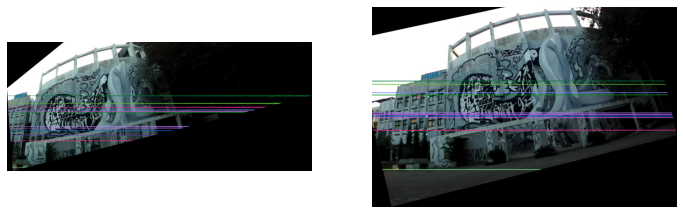

In [85]:
pair_3 = read_files_q2(3)
F, left_pts, right_pts = get_fundamental_matrix(pair_3)
pair_3 = plot_epipolar_lines(pair_3, left_pts, right_pts, F, 15)
pair_3 = stereo_rectify(pair_3, F, left_pts, right_pts)
show(pair_3)

Greedy intensity based row-wise matching

In [92]:
def intensity_window_correlation_greedy(pair_, num=NUM_POINTS, win_sz=WINDOW_SIZE):
    pair = StereoPair(cv.cvtColor(pair_.left, cv.COLOR_RGB2GRAY), cv.cvtColor(pair_.right, cv.COLOR_RGB2GRAY))

    left_pts = get_safe_points(pair.left.shape, pair.right.shape, win_sz+1, num)
    right_pts = []

    for (i, j) in left_pts:
        neigh = pair.left[i-win_sz:i+win_sz, j-win_sz:j+win_sz]
        search_space = pair.right[i-win_sz:i+win_sz+1, win_sz:-win_sz]
        selected = get_corr_match(neigh, search_space, win_sz)
        selected = (selected[0] + i - win_sz, selected[1] + win_sz)
        right_pts.append(selected)
    
    left_pts = np.array(left_pts)
    right_pts = np.array(right_pts)

    fig, (axl, axr) = show(pair_, False)
    colors = np.random.uniform(low=0, high=1, size=left_pts.shape[0])
    axl.scatter(left_pts[:, 1], left_pts[:, 0], s=15, alpha=0.8, cmap='rainbow', c=colors)
    axr.scatter(right_pts[:, 1], right_pts[:, 0], s=15, alpha=0.8, cmap='rainbow', c=colors)
    plt.show()


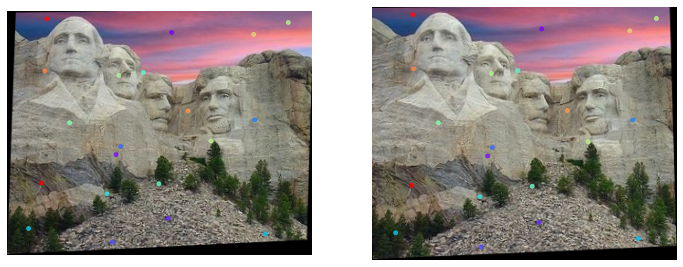

In [94]:
pair_1 = read_files_q2(1)
F, left_pts, right_pts = get_fundamental_matrix(pair_1)
pair_1 = stereo_rectify(pair_1, F, left_pts, right_pts)
intensity_window_correlation_greedy(pair_1)

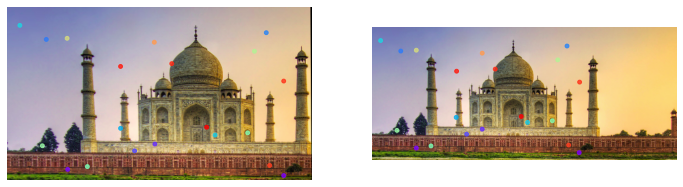

In [95]:
pair_1 = read_files_q2(2)
F, left_pts, right_pts = get_fundamental_matrix(pair_1)
pair_1 = stereo_rectify(pair_1, F, left_pts, right_pts)
intensity_window_correlation_greedy(pair_1)

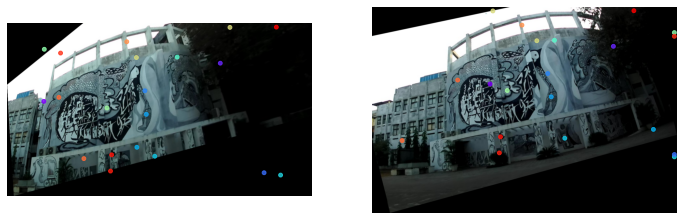

In [98]:
pair_1 = read_files_q2(3)
F, left_pts, right_pts = get_fundamental_matrix(pair_1)
pair_1 = stereo_rectify(pair_1, F, left_pts, right_pts)
intensity_window_correlation_greedy(pair_1)